Contours: 6 | kept: 6


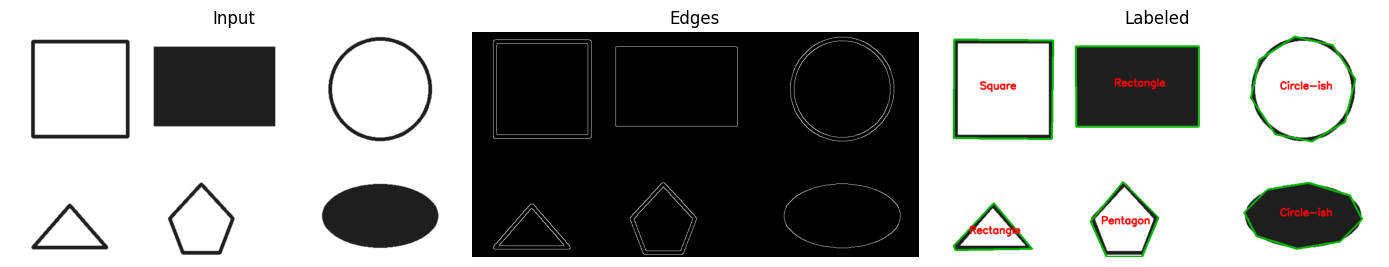

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMAGE_PATH = "./2_2_test.png"
img = cv2.imread(IMAGE_PATH)
if img is None:
    raise FileNotFoundError(f"Không đọc được ảnh: {IMAGE_PATH}")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 1.0)

low, high = 50, 150
edges = cv2.Canny(blur, low, high)

# (khuyến nghị) nối biên cho dễ tìm contour
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
edges2 = cv2.dilate(edges, kernel, iterations=1)
edges2 = cv2.morphologyEx(edges2, cv2.MORPH_CLOSE, kernel, iterations=2)

contours, _ = cv2.findContours(edges2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

min_area = 100
kept = [c for c in contours if cv2.contourArea(c) >= min_area]

def classify_shape(cnt):
    peri = cv2.arcLength(cnt, True)
    if peri == 0:
        return None, None
    approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
    v = len(approx)
    area = cv2.contourArea(cnt)
    if area < min_area:
        return None, approx

    if v == 3:
        return "Triangle", approx
    if v == 4:
        x, y, w, h = cv2.boundingRect(approx)
        ar = w / float(h) if h > 0 else 0
        if 0.90 <= ar <= 1.10:
            return "Square", approx
        return "Rectangle", approx
    if v == 5:
        return "Pentagon", approx

    circularity = 4 * np.pi * area / (peri * peri)
    if circularity > 0.78:
        return "Circle-ish", approx
    return "Polygon", approx

out = img.copy()

for cnt in kept:
    label, approx = classify_shape(cnt)
    if label is None:
        continue
    cv2.drawContours(out, [approx], -1, (0, 180, 0), 3)
    M = cv2.moments(cnt)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        cv2.putText(out, label, (cx - 55, cy),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2, cv2.LINE_AA)

print("Contours:", len(contours), "| kept:", len(kept))

plt.figure(figsize=(14,5))
plt.subplot(1,3,1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.title("Input")
plt.subplot(1,3,2); plt.imshow(edges, cmap="gray"); plt.axis("off"); plt.title("Edges")
plt.subplot(1,3,3); plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.title("Labeled")
plt.tight_layout()
plt.show()
